In [1]:
import pandas as pd
import numpy as np

uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"
dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


In [2]:
# situação horrível de "azar" onde as classes estão ordenadas por padrão

dados_azar = dados.sort_values("vendido", ascending=True)
x_azar = dados_azar[["preco", "idade_do_modelo","km_por_ano"]]
y_azar = dados_azar["vendido"]
dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


In [3]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier

SEED = 301
np.random.seed(SEED)

modelo = DummyClassifier()
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com dummy stratified, 10 = [58.00, 58.00]


In [4]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

SEED = 301
np.random.seed(SEED)

modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com cross validation, 10 = [73.83, 77.73]


In [5]:
# gerando dados elatorios de modelo de carro para simulacao de agrupamento ao usar nosso estimador

np.random.seed(SEED)
dados['modelo'] = dados.idade_do_modelo + np.random.randint(-2, 3, size=10000)
dados.modelo = dados.modelo + abs(dados.modelo.min()) + 1
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


In [6]:
def imprime_resultados(results):
  media = results['test_score'].mean() * 100
  desvio = results['test_score'].std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [7]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 75.78
Intervalo [73.67, 77.90]


In [8]:
# GroupKFold em um pipeline com StandardScaler e SVC

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

SEED = 301
np.random.seed(SEED)

scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([('transformacao',scaler), ('estimador',modelo)])

cv = GroupKFold(n_splits = 10)
results = cross_validate(pipeline, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 76.68
Intervalo [74.28, 79.08]


In [9]:
from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)

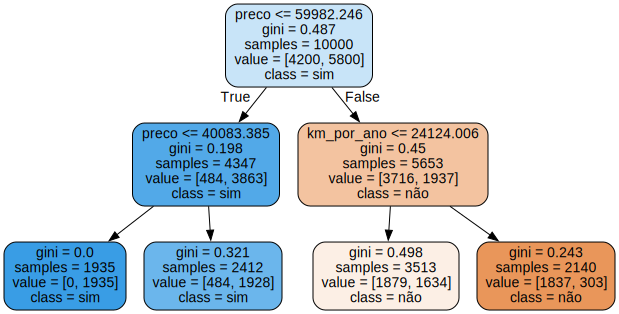

In [10]:
import graphviz
from sklearn.tree import export_graphviz

modelo.fit(x_azar, y_azar)
features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True, class_names=['não', 'sim'], feature_names= features)
graph = graphviz.Source(dot_data)
graph

In [18]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits=10)
    modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    results = cross_validate(modelo, x_azar, y_azar, cv=cv, groups=dados.modelo, return_train_score=True)
    train_score = results['train_score'].mean() * 100
    test_score = results['test_score'].mean() * 100
    print('Arvore max_depth = %d, min_samples_leaf %d, treino = %.2f, teste = %.2f' % (max_depth, min_samples_leaf,train_score, test_score))
    tabela = [max_depth, min_samples_leaf, train_score, test_score]
    return tabela

def busca():
    resultados = []
    for max_depth in range(1, 33):
        for min_samples_leaf in [32, 64, 128, 256]:
            tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
            resultados.append(tabela)
    resultados = pd.DataFrame(resultados, columns=['max_depth', 'min_samples_leaf','train', 'test'])
    return resultados

resultados = busca()
resultados.head()

Arvore max_depth = 1, min_samples_leaf 32, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf 64, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf 128, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf 256, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf 32, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf 64, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf 128, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf 256, treino = 75.79, teste = 75.78
Arvore max_depth = 3, min_samples_leaf 32, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf 64, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf 128, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf 256, treino = 78.75, teste = 78.67
Arvore max_depth = 4, min_samples_leaf 32, treino = 78.75, teste = 78.67
Arvore max_depth = 4, min_samples_leaf 64, tr

,max_depth,min_samples_leaf,train,test
0,1,32,75.791169,75.784219
1,1,64,75.791169,75.784219
2,1,128,75.791169,75.784219
3,1,256,75.791169,75.784219
4,2,32,75.791169,75.784219


In [19]:
resultados.sort_values('test', ascending=False).head()

,max_depth,min_samples_leaf,train,test
15,4,256,78.750993,78.672633
12,4,32,78.750993,78.672633
14,4,128,78.750993,78.672633
13,4,64,78.750993,78.672633
8,3,32,78.750993,78.672633


In [20]:
resultados.corr()

,max_depth,min_samples_leaf,train,test
max_depth,1.000000e+00,-2.780775e-16,0.536705,-0.027675
min_samples_leaf,-2.780775e-16,1.000000e+00,-0.409676,0.349011
train,5.367048e-01,-4.096762e-01,1.000000,0.116466
test,-2.767507e-02,3.490111e-01,0.116466,1.000000


In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold
import numpy as np
from sklearn.tree import DecisionTreeClassifier

SEED = 301
np.random.seed(SEED)

espaco_de_parametros = {
    'max_depth': [3, 5],
    'min_samples_split': [32, 64, 128],
    'min_samples_leaf': [32, 64, 128],
    'criterion' : ['gini', 'entropy']
}

busca = GridSearchCV(DecisionTreeClassifier(), espaco_de_parametros, cv=KFold(n_splits=10, shuffle=True))
busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.013100,0.002427,0.002500,0.000501,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.767,...,0.774,0.813,0.792,0.796,0.79,0.78,0.779,0.787,0.013229,1
1,0.010300,0.001734,0.001800,0.000400,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.767,...,0.774,0.813,0.792,0.796,0.79,0.78,0.779,0.787,0.013229,1
2,0.009800,0.001166,0.001801,0.000400,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.767,...,0.774,0.813,0.792,0.796,0.79,0.78,0.779,0.787,0.013229,1
3,0.009200,0.001076,0.001701,0.000458,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.767,...,0.774,0.813,0.792,0.796,0.79,0.78,0.779,0.787,0.013229,1
4,0.010607,0.001748,0.001795,0.000747,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.767,...,0.774,0.813,0.792,0.796,0.79,0.78,0.779,0.787,0.013229,1


In [32]:
print(busca.best_params_)
print(busca.best_score_)
melhor = busca.best_estimator_

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
0.787


In [29]:
melhor

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

In [33]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca, x_azar, y_azar, cv=KFold(n_splits=10, shuffle=True))

In [34]:
def imprime_score(scores):
    media = scores.mean() * 100
    desvio = scores.std() * 100
    print("Accuracy médio %.2f" % media)
    print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [35]:
imprime_score(scores)

Accuracy médio 78.69
Intervalo [76.13, 81.25]


In [36]:
scores

array([0.772, 0.768, 0.795, 0.785, 0.789, 0.786, 0.796, 0.773, 0.813,
       0.792])